# Symbolic function manipulation using BDDs

> **Before you begin: You don't really need to understand BDDs to analyse Boolean networks with AEON. Most readers will be just fine skipping to the next tutorial :) However, BDDs are the underlying bedrock of most algorithms in AEON. Hence it is useful to have at least some basic knowledge of BDDs for any in-depth work.**

This notebook shows examples of how to use binary decision diagrams (BDDs) available in the AEON.py tool. It assumes that you already know what BDDs are and their capabilities (i.e., we will not talk about BDDs, just the technical implementation of the library). For a quick overview of BDDs, [wikipedia](https://en.wikipedia.org/wiki/Binary_decision_diagram) is an ok resource.

<p align="center">
  <img style="margin: 0 auto; display: block;" src="./img/bdd_example.png" />
</p>

Compared to other BDD libraries, here we do not have a single shared "BDD storage" or "BDD manager". Instead, **every BDD is a separate object**, which means it is easier to pass it around during asynchronous or parallel computing (i.e. more than one BDD operation can be running at the same time). It also simplifies serialization and managing multiple BDD encodings at the same time.

That being said, we still use a separate `BddVariableSet` to manage the mapping from *names* to the actual BDD variable IDs, since variable names are not used as often and there is no need to have a copy of all names in each BDD. This `BddVariableSet` object is also used to initially create BDD atoms, so it is probably the first thing that you'll need to setup before creating any BDDs. Furthermore, each BDD actually maintains the *total number* of variables that it supports. This is injected by the `BddVariableSet`. **You can't mix BDDs with a different variable count**. In practice, you should only combine BDDs created using the same `BddVariableSet` unless you absolutely know what you are doing.

To begin, simply install AEON.py from PyPI (`pip install biodivine_aeon`) and import everything:

In [1]:
from biodivine_aeon import *

Detected IPython (`ZMQInteractiveShell`). Log level set to `LOG_ESSENTIAL`.


### `BddVariableSet` and creating basic BDDs

To create a `BddVariableSet`, you have two options: If you already know the number of variables (and their names), you can create it directly. Alternatively, you can create it gradually using a `BddVariableSetBuilder` while figuring out what variables to use.

In [2]:
# Create a BddVariableSet with 5 variables named "a", "b", "c", "d", "e".
vars = BddVariableSet(["a", "b", "c", "d", "e"])
assert vars.variable_count() == 5
# To actually use the variables in the future, we have to use a `BddVariable` reference. 
# Here, v_a now contains a `BddVariable` reference. 
# In most methods, you can also use the variable names directly, but this is typically slower,
# because the names need to be resolved to IDs every time.
v_a = vars.find_variable("a")
v_c = vars.find_variable("c")

# These `BddVariable` references are internally just integers:
assert BddVariable(int(v_a)) == v_a

# We can use the `BddVariable` reference to create a literal.
# (A literal is a BDD that corresponds either to function "a" or "!a")
positive_bdd_literal = vars.mk_literal(v_a, True)
negative_bdd_literal = vars.mk_literal(v_a, False)

# We can achieve the same thing using the variable name. But, as noted,
# this is slightly slower, so it's better to use variable references 
# in performance critical parts of the program.
assert positive_bdd_literal == vars.mk_literal("a", True)

# We can also use the variable set to create constants:
bdd_true = vars.mk_const(True)

# Test whether a particular function is equivalent to 
# the `true` constant (i.e. a tautology).
assert positive_bdd_literal.is_true() == False
assert bdd_true.is_true() == True  

# You can also create an "anonymous" variable set, where the names of the variables are 
# automatically set to "x_0", "x_1", ... , "x_{n-1}".
anonymous_vars = BddVariableSet(10)

# It is always possible to retrieve all variables valid in a set:
anonymous_ids = anonymous_vars.variable_ids()
anonymous_names = anonymous_vars.variable_names()

for i in range(len(anonymous_ids)):
    assert anonymous_names[i] == anonymous_vars.get_variable_name(anonymous_ids[i])

anonymous_names

['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']

In some cases, you don't know the number (or names) of variables initially. For example, you want to have a function that creates the variables while reading the problem input, and saves the BDD variable references for future use:

In [3]:
builder = BddVariableSetBuilder()

# You can create variables one by one, and the builder will always give you the variable reference for later use.
v_first: BddVariable = builder.add("first")

# You can also create multiple variable at the same time if you want to.
created: list[BddVariable] = builder.add_all(["second", "third", "fourth"])
v_third = created[1]

# In the end, you can just call `build` to turn the builder into a valid `BddVariableSet`.
four_vars = builder.build()
four_vars.variable_names()

['first', 'second', 'third', 'fourth']

Note that AEON will throw an exception if you try to define a duplicate variable:

In [4]:
try:
    builder.add("first")
except:
    print("Variable already exists")

Variable already exists


thread '<unnamed>' panicked at /Users/daemontus/.cargo/registry/src/index.crates.io-6f17d22bba15001f/biodivine-lib-bdd-0.5.11/src/_impl_bdd_variable_set_builder.rs:30:13:
BDD variable first already exists.
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


Furthermore, some special characters (like `!`, or other logical operators) cannot be used in a variable names. The reason for this is mainly that `BddVariableSet` can actually do quite a bit more than what we've shown already:

In [5]:
# If you have a formula that you want to quickly turn into a BDD, you can simply evaluate it as a string,
# as long as the variable names match the ones declared in your BddVariableSet.
formula = vars.eval_expression("a & (b => !c) & (d <=> (c & !a))")

# Furthermore, if you have a formula saved in CNF/DNF, you can also build it quite easily.
# Each element in the list is a dictionary containing the literals in the CNF/DNF clause. 
# Here, both `BddVariable` references and names are accepted.
conjunction = vars.mk_cnf([{v_a: True, "b": False}, {"c": False, "d": False}, {v_a: True, "c": True}])

# If you only want to create one clause, you can do that as well:
clause = vars.mk_conjunctive_clause({v_a: True, "b": False, "c": True})
clause.cardinality() # Get the number of valuations satisfied in this BDD.

4

### `BooleanExpression`

Boolean expressions are actually a separate Python class that you can use in conjunction with BDDs to represent arbitrary Boolean functions:

In [6]:
# Each expression variant has a corresponding `mk_*` method:
e_1 = BooleanExpression.mk_var("a")
# But you can also create expressions from strings:
e_2 = BooleanExpression("b => !c")
e_3 = BooleanExpression("d <=> (c & !a)")

e = BooleanExpression.mk_conjunction([e_1, e_2, e_3])

# For each expression variant, you can check it's type using the `is_*` methods:
assert e.is_and()
assert e_3.is_iff()

# Finally, to "deconstruct" an expression, you can use the `as_*` methods:
(e_3a, e_3b) = e_3.as_iff()
assert e_3a.is_var()
assert e_3b.is_and()

print(e)

(a & ((b => !c) & (d <=> (c & !a))))


Of course, a BDD can be converted back into an expression. This conversion is based on the disjunctive normal form of a BDD, which we demonstrate later.

In [7]:
formula.to_expression()

BooleanExpression("(a & ((b & (!c & !d)) | (!b & !d)))")

### BDDs in depth

First of all, every BDD is a Boolean function. As such, you can just evaluate it given a correct number of input values:

In [8]:
print(formula([True, False, False, True, True]))
print(formula([True, True, False, False, True]))

False
True


You can iterate through the satisfying valuations of the BDD (the rows of the function table that are set to `true`):

In [9]:
for valuation in formula.valuation_iterator():
    print(valuation)

[1,0,0,0,0]
[1,0,1,0,0]
[1,0,0,0,1]
[1,0,1,0,1]
[1,1,0,0,0]
[1,1,0,0,1]


Alternatively, you can also iterate through the DNF clauses of the BDD that represent the paths to the `1` node. These effectively represent the same information as the function table rows, but more compactly:

In [10]:
for clause in formula.clause_iterator():
    print(clause)

{'a': 1, 'b': 0, 'd': 0}
{'a': 1, 'b': 1, 'c': 0, 'd': 0}


##### BDD structure

First, you can explore the individual nodes of the underlying BDD graph.

> BDDs are immutable. You can read their structure, but to modify it, you have to create a new BDD.

In [11]:
stack = [ formula.root() ]
expanded = set()
while len(stack) > 0:
    node = stack.pop()
    if node in expanded:
        continue
    expanded.add(node)
    node_var = formula.node_variable(node)
    (low_link, high_link) = formula.node_links(node)
    print(f"Node {node} conditions on {node_var} and points to ({low_link}, {high_link})")
    stack.append(high_link)
    stack.append(low_link)

Node node_5 conditions on x_0 and points to (node_0, node_4)
Node node_0 conditions on None and points to (node_0, node_0)
Node node_4 conditions on x_1 and points to (node_2, node_3)
Node node_2 conditions on x_3 and points to (node_1, node_0)
Node node_1 conditions on None and points to (node_1, node_1)
Node node_3 conditions on x_2 and points to (node_2, node_0)


To visually inspect the BDD structure, you can also use a conversion to a `.dot` graph file.

Here, we are using `graphviz` to actually show the pictures of the decision diagrams:

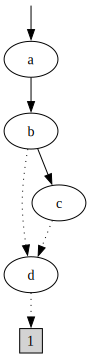

In [12]:
import graphviz

graphviz.Source(formula.to_dot())

For readability, the generated plot omits edges that lead to the `zero` terminal node, as these are easy to infer visually. We can still show them if desired:

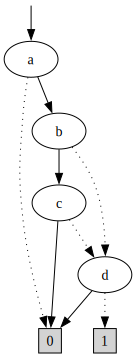

In [13]:
graphviz.Source(formula.to_dot(zero_pruned=False))

To resolve the `BddVariable` references to proper variable names, `Bdd` uses an internal reference to the `BddVariableSet` that originally created it. In Python, this reference is accessible through `Bdd.__ctx__()`:

In [14]:
assert formula.__ctx__() == vars

Finally, to understand the underlying Boolean function, you can also convert a `Bdd` to a disjunctive or conjunctive normal form:

In [15]:
print("DNF")
for clause in formula.to_dnf():
    print(clause)
print("CNF")
for clause in formula.to_cnf():
    print(clause)

DNF
{'a': 1, 'b': 1, 'c': 0, 'd': 0}
{'a': 1, 'b': 0, 'd': 0}
CNF
{'a': 1}
{'a': 0, 'b': 1, 'd': 0}
{'a': 0, 'b': 0, 'c': 1, 'd': 0}
{'a': 0, 'b': 0, 'c': 0}


Note that the result of `formula.to_dnf()` and `formula.clause_iterator()` is functionally very similar, as both produce a discjuntive normal form of the corresponding BDD. However, when using `to_dnf`, AEON performs additional simplification to (ideally) produce a smaller number of clauses overall.

##### Logical operators

To actually manipulate BDDs, you can use normal logical operators, as well as more advanced relation operators (projection, selection, restriction, ...). However, note that because `and` and `or` are Python keywords, the actual methods are prefixed with `l_*` (logical operators) and `r_*` (relation operators) to clearly differentiate them from the built-in language constructs.

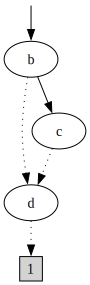

In [16]:
# Basic logical operators:

formula.l_and(conjunction)
formula.l_or(conjunction)
formula.l_xor(conjunction)
formula.l_imp(conjunction)
formula.l_iff(conjunction)
formula.l_and_not(conjunction)

# Projection, either using one variable, or a set of variables.
formula.r_exists([v_a, v_c])
formula.r_for_all([v_a, v_c])

# Projection "removes" the influence of a particular variable: F = F[a/0] | F[a/1]
graphviz.Source(formula.r_exists(v_a).to_dot())

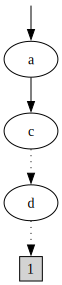

In [17]:
# Similarly, we can use selection to actually fix a variable to a specific value.
# Here, we have to also include the Boolean value to which we are fixing. 
# The argument is therefore a dictionary.
graphviz.Source(formula.r_select({ v_c: False }).to_dot())

##### BDD serialization

Finally, to transfer and save BDDs, you can use string and byte formats that encode the internal directed acyclic graph of the BDD:

In [18]:
assert Bdd(vars, formula.data_string()) == Bdd(vars, formula.data_bytes())

formula.data_string()

'|5,0,0|5,1,1|3,1,0|2,2,0|1,2,3|0,0,4|'

This representation does not preserve the underlying `BddVariableSet` of the `Bdd` (you'll have to save that separately). However, we can also use `pickle`. Here, the representation is not as efficient, but it preserves all the information in one data bundle:

In [19]:
import pickle
assert formula == pickle.loads(pickle.dumps(formula))

Now we've covered the basic portion of the BDD functionality. For more details, you can explore the API documentation of the `Bdd` class [here](https://biodivine.fi.muni.cz/docs/aeon-py/latest/).